# Experiment 1: CNN 

## Import Packages¶

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import random
import os
import cv2

import tensorflow as tf
# import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
# from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
# import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

2024-12-16 08:15:21.713223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
directory='/Users/alexmak/Desktop/CMPUT/School/Year_6/RADDI_514/Project/Lung_Tumor_Detection_Project/Data/Training_Cases'

categories = ['Benign_Cases', 'Malignant_Cases', 'Normal_Cases']

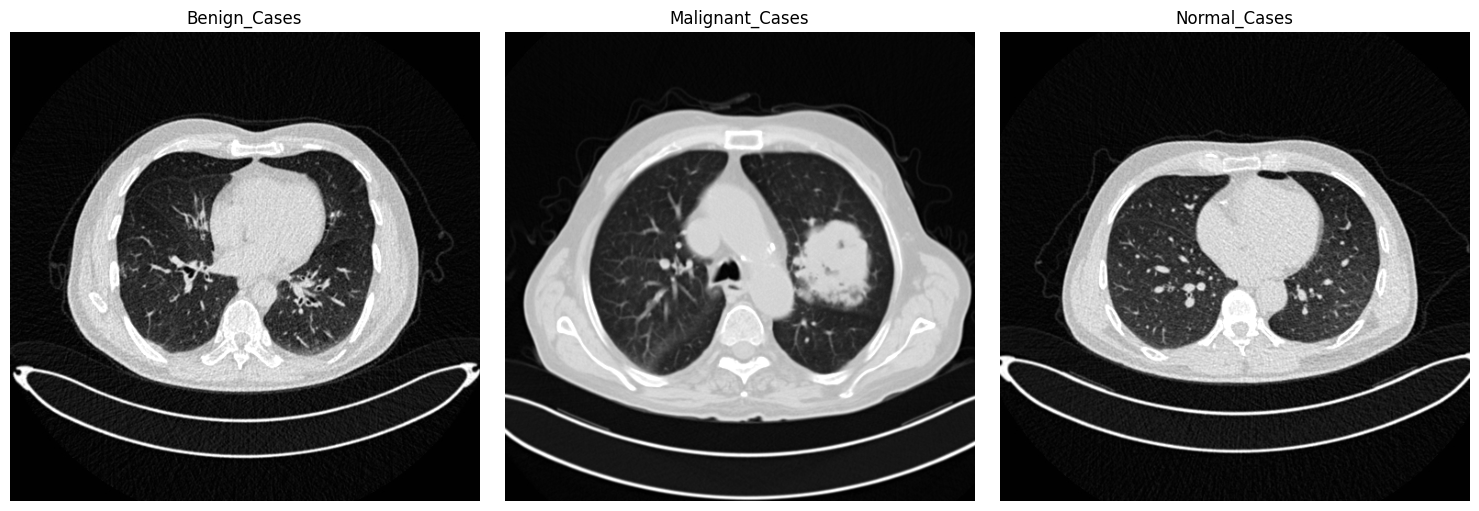

In [3]:
image_index = 1

fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))  
for idx, i in enumerate(categories):
    path = os.path.join(directory, i)
    # Sort files alphabetically to ensure same pictures are shown everytime
    files = sorted(os.listdir(path)) 
    
    if len(files) > image_index:  
        filepath = os.path.join(path, files[image_index]) 
        img = cv2.imread(filepath, 0)
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"{i}")
        axes[idx].axis('off')  

plt.tight_layout()
plt.show()

## image processing and testing

## Preparing Data

## Image Loading & Processing

In [5]:
data = []
img_size = 256

# Store the original and processed images for visualization
original_images = []
processed_images = []

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0) 
        if img is None: 
            continue
        
        # Save the original image for visualization
        original_images.append(img)
        
        # Preprocess: Resize image
        img_processed = cv2.resize(img, (img_size, img_size))

        # Preprocess: contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_processed = clahe.apply(img_processed)

        processed_images.append(img_processed)
        data.append([img_processed, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# Preprocess: Normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)


X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


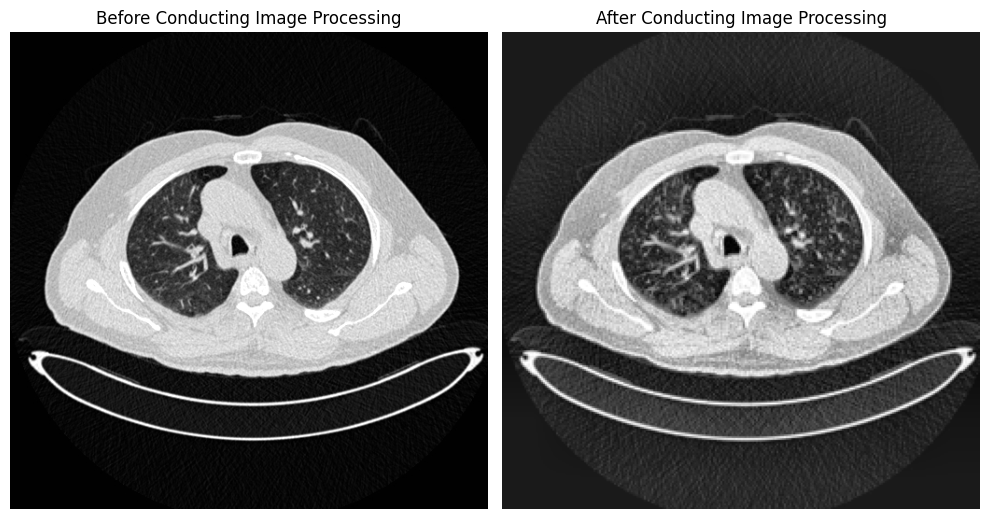

In [6]:
# Visualize before and after preprocessing
num_samples = 1  # Number of samples to display
plt.figure(figsize=(10, 6))

for idx in range(num_samples):
    if idx >= len(original_images):
        break
    
    # Show original image
    plt.subplot(num_samples, 2, 2 * idx + 1)
    plt.imshow(original_images[idx], cmap='gray')
    plt.title("Before Conducting Image Processing")
    plt.axis('off')

    # Show processed image
    plt.subplot(num_samples, 2, 2 * idx + 2)
    plt.imshow(processed_images[idx], cmap='gray')
    plt.title("After Conducting Image Processing")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)

# Preprocess: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Generate augmented samples for the training set
augmented_images = []
augmented_labels = []

for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]
    for _ in range(5):  # Generate 5 augmented images (variants) per original image
        augmented_img = datagen.random_transform(img)
        augmented_images.append(augmented_img)
        augmented_labels.append(label)

# Convert augmented data to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine original and augmented training data
X_train_aug = np.vstack([X_train, augmented_images])
y_train_aug = np.hstack([y_train, augmented_labels])

print("Training dataset after augmentation:", Counter(y_train_aug))

# APPLY SMOTE IF NEEDED
# # # Step 4: Apply SMOTE
# # # Flatten the images for SMOTE
# X_train_flat = X_train_aug.reshape(X_train_aug.shape[0], -1)

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_aug)

# # Reshape back to image dimensions
# X_train_resampled = X_train_resampled.reshape(-1, img_size, img_size, 1)

# print("Training dataset after SMOTE:", Counter(y_train_resampled))

Training dataset after augmentation: Counter({1: 1344, 2: 996, 0: 288})


In [8]:
print("Testing dataset:", Counter(y_test))

Testing dataset: Counter({1: 337, 2: 250, 0: 72})


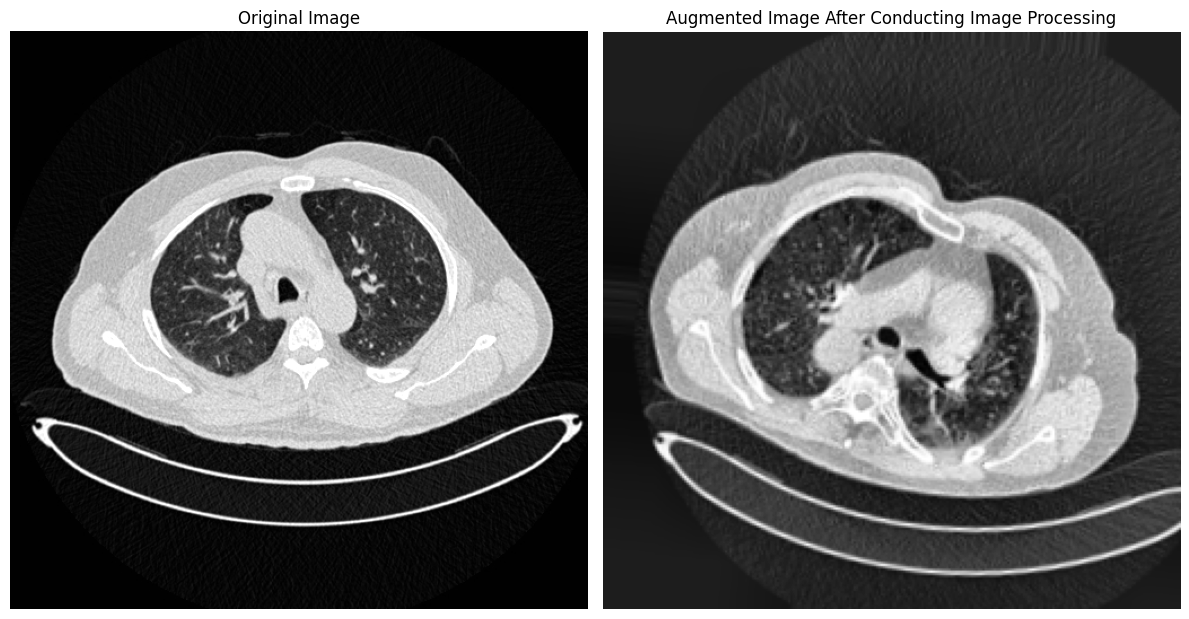

In [9]:
# Visualize Data Augmentation compare to original image
plt.figure(figsize=(12, 8))

# Show an augmented image
plt.subplot(1, 2, 1)
plt.imshow(original_images[idx], cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_images[i].reshape(img_size, img_size), cmap='gray')
plt.title("Augmented Image After Conducting Image Processing")
plt.axis('off')

# # Show a SMOTE image
# plt.subplot(2, 5, i + 6)
# plt.imshow(X_train_resampled[i].reshape(img_size, img_size), cmap='gray')
# plt.title("SMOTE")
# plt.axis('off')

plt.tight_layout()
plt.show()

# CNN Modeling

In [13]:
# Further split test into test and valid (so now 80-10-10)
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
)

In [14]:
# verify shape
print(X_train_aug.shape)
print(X_val.shape)
print(X_test_final.shape)

(2628, 256, 256, 1)
(329, 256, 256, 1)
(330, 256, 256, 1)


In [10]:
# confirm image shape to match up
X_train_aug.shape[1:]

(256, 256, 1)

### MODEL 1: CNN

In [11]:
model1 = Sequential()

# Define input shape explicitly
model1.add(Input(shape=X_train_aug.shape[1:]))

model1.add(Conv2D(16, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(16, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(8))
model1.add(Dense(3, activation='softmax'))

model1.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 254, 254, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       492,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494,547 (1.89 MB)

 Trainable params: 494,547 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile CNN Model
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Fitting CNN Model with validtion data
history1 = model1.fit(X_train_aug, y_train_aug, batch_size=8, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 218ms/step - accuracy: 0.6144 - loss: 0.9276 - val_accuracy: 0.8328 - val_loss: 0.4414
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 68s 174ms/step - accuracy: 0.7723 - loss: 0.5636 - val_accuracy: 0.9574 - val_loss: 0.2046
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 55s 167ms/step - accuracy: 0.8754 - loss: 0.3255 - val_accuracy: 0.8875 - val_loss: 0.2576
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.9393 - loss: 0.1916 - val_accuracy: 0.9757 - val_loss: 0.0803
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 56s 171ms/step - accuracy: 0.9788 - loss: 0.0782 - val_accuracy: 0.9422 - val_loss: 0.1403
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 54s 163ms/step - accuracy: 0.9899 - loss: 0.0378 - val_accuracy: 0.9635 - val_loss: 0.1129
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - accuracy: 0.9945 - loss: 0.0199 - val_accuracy: 0.9422 - val_loss: 0.1546
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - accuracy: 0.9809 - loss: 0

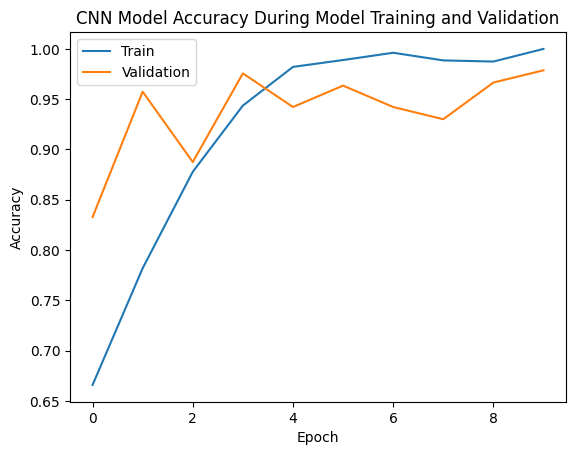

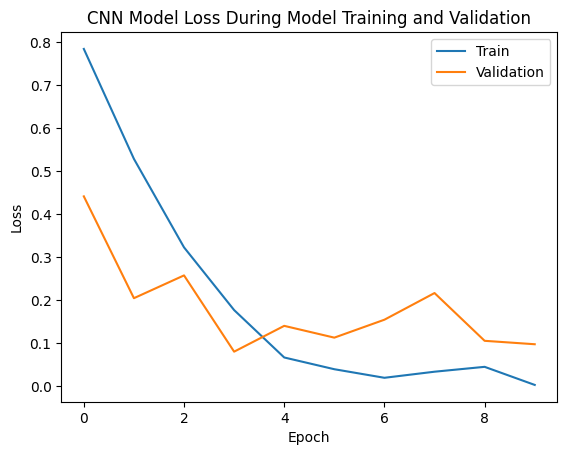

In [34]:
# print validation accuracy and loss over epoch
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('CNN Model Accuracy During Model Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Validation')
plt.title('CNN Model Loss During Model Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Evaluation

In [16]:
# Make Predictions
y_pred_1 = model1.predict(X_test_final, verbose=1)
# Convert predicted probabities to class 
y_pred_bool_1 = np.argmax(y_pred_1, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step


In [46]:
# Fixed class labels for all evaluations
class_labels = {0: "Benign", 1: "Malignant", 2: "Normal"}

def evaluate_predictions(y_test, y_pred, y_pred_bool):
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_bool, target_names=class_labels.values()))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred_bool)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="coolwarm", fmt="d", xticklabels=class_labels.values(), yticklabels=class_labels.values())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred_bool)
    print(f"\nAccuracy: {accuracy:.4f}")

    # Recall and Precision
    recall_weighted = recall_score(y_test, y_pred_bool, average="weighted")
    precision_weighted = precision_score(y_test, y_pred_bool, average="weighted")
    print(f"\nRecall (Weighted): {recall_weighted:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")

    # Specificity for each class
    specificity = {}
    for i in range(conf_matrix.shape[0]):
        tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
        fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
        specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Overall Specificity and Sensitivity
    overall_specificity = np.mean(list(specificity.values()))
    overall_sensitivity = recall_score(y_test, y_pred_bool, average="macro")
    print(f"\nOverall Specificity: {overall_specificity:.4f}")
    print(f"Overall Sensitivity: {overall_sensitivity:.4f}")


    # Class-wise Performance Metrics Heatmap
    classification_report_dict = classification_report(y_test, y_pred_bool, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    class_metrics = {metric: [classification_report_dict[str(cls)][metric] for cls in range(len(class_labels))] for metric in metrics}

    # print(classification_report_dict)

    # # Add accuracy, micro avg, and weighted avg to the heatmap
    # class_metrics['accuracy'] = [accuracy] * len(class_labels)
    # class_metrics['macro avg'] = [classification_report_dict['macro avg'][metric] for metric in metrics] + [accuracy]
    # class_metrics['weighted avg'] = [classification_report_dict['weighted avg'][metric] for metric in metrics] + [accuracy]

    plt.figure(figsize=(10, 6))
    sns.heatmap(data=pd.DataFrame(class_metrics, index=class_labels.values()), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Class-wise Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()

    # AUC-ROC Curve (One-vs-Rest for Multiclass)
    if len(np.unique(y_test)) > 2:
        # Binarize the labels for multiclass ROC calculation
        y_test_binary = np.zeros((y_test.size, len(np.unique(y_test))))
        for i, label in enumerate(y_test):
            y_test_binary[i, label] = 1

        roc_auc_weighted = roc_auc_score(y_test_binary, y_pred, average="weighted", multi_class="ovr")
        print(f"\nAUC-ROC (Weighted): {roc_auc_weighted:.4f}")

        plt.figure(figsize=(10, 7))
        for i in range(len(np.unique(y_test))):
            fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
            plt.plot(fpr, tpr, label=f"Class {class_labels[i]} (AUC = {auc(fpr, tpr):.2f})")
        plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
        plt.title("AUC-ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(10, 7))
    for i in range(len(np.unique(y_test))):
        precision, recall, _ = precision_recall_curve(y_test_binary[:, i], y_pred[:, i])
        plt.plot(recall, precision, label=f"Class {class_labels[i]}")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()



Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.67      0.75        36
   Malignant       0.99      0.99      0.99       169
      Normal       0.91      0.97      0.94       125

    accuracy                           0.95       330
   macro avg       0.92      0.88      0.89       330
weighted avg       0.95      0.95      0.95       330


Confusion Matrix:
[[ 24   1  11]
 [  0 168   1]
 [  4   0 121]]


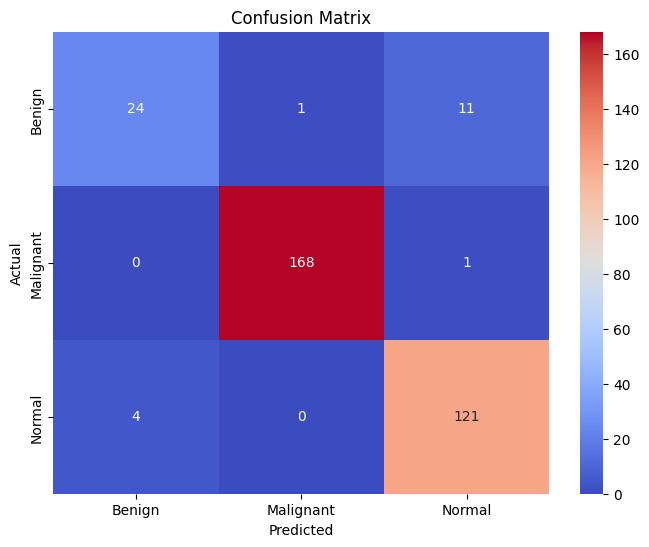


Accuracy: 0.9485

Recall (Weighted): 0.9485
Precision (Weighted): 0.9472

Overall Specificity: 0.9739
Overall Sensitivity: 0.8762


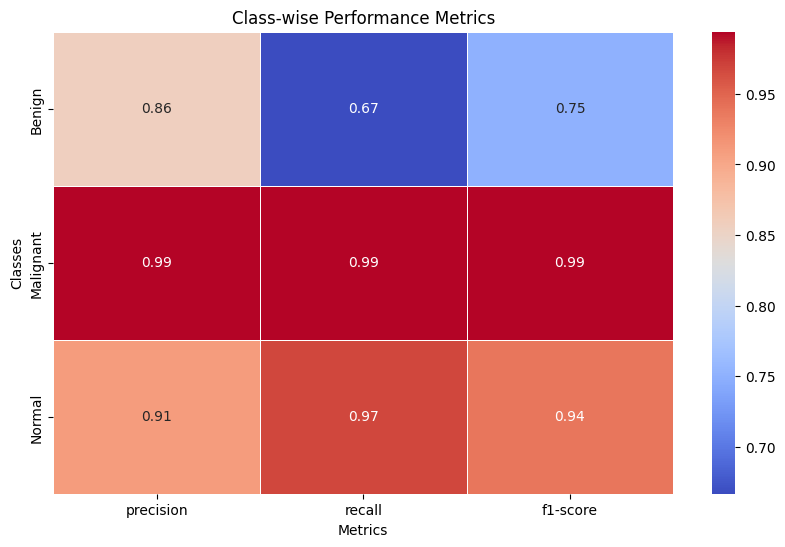


AUC-ROC (Weighted): 0.9950


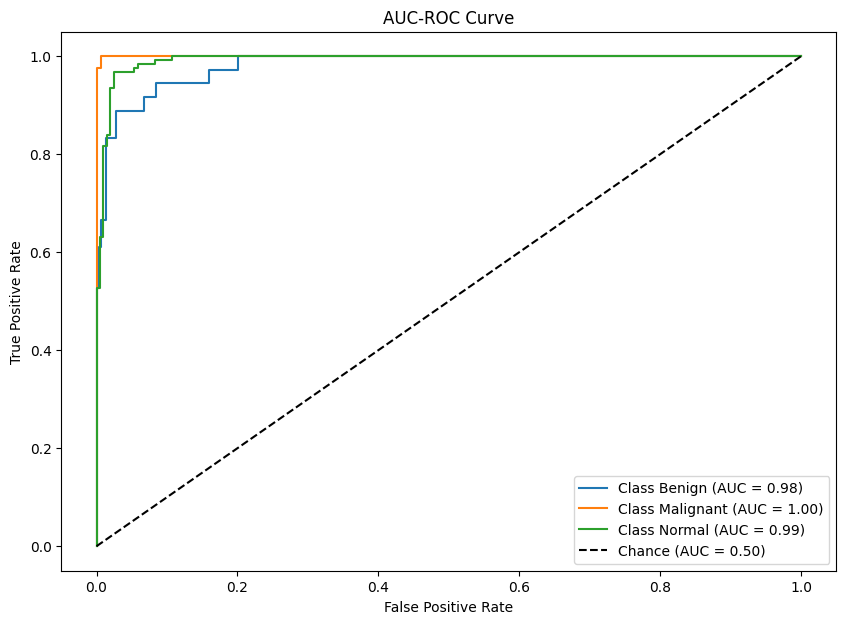

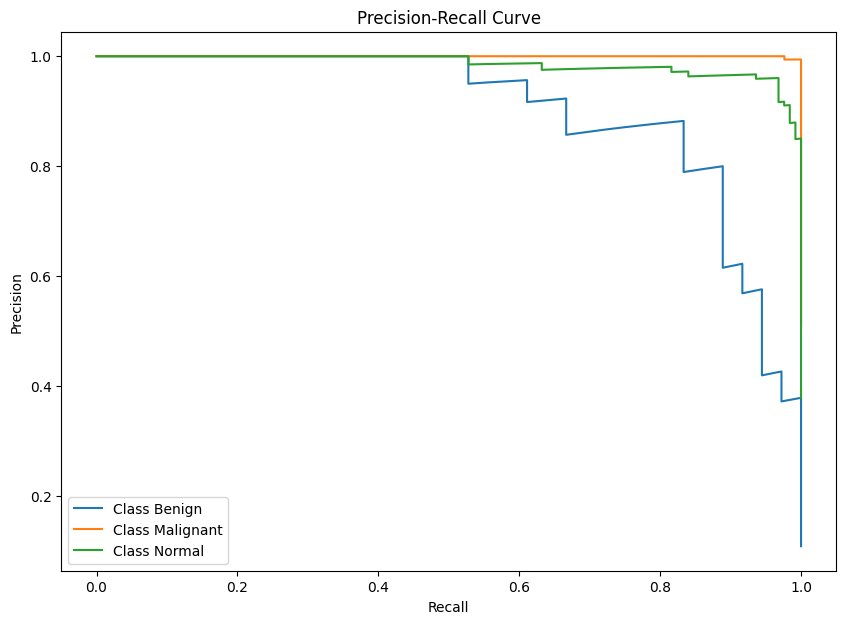

In [47]:
# run defined function
evaluate_predictions(y_test_final, y_pred_1, y_pred_bool_1)

#### Model Saving

In [37]:
model1.save("CNN_model(final).keras")

In [38]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model1 = load_model("CNN_model(final).keras")

In [39]:
# Make Predictions from the loaded model (to verify impact)

y_pred_1_loaded = loaded_model1.predict(X_test_final, verbose=1)
y_pred_bool_1_loaded = np.argmax(y_pred_1_loaded, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step



Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.67      0.75        36
   Malignant       0.99      0.99      0.99       169
      Normal       0.91      0.97      0.94       125

    accuracy                           0.95       330
   macro avg       0.92      0.88      0.89       330
weighted avg       0.95      0.95      0.95       330


Confusion Matrix:
[[ 24   1  11]
 [  0 168   1]
 [  4   0 121]]


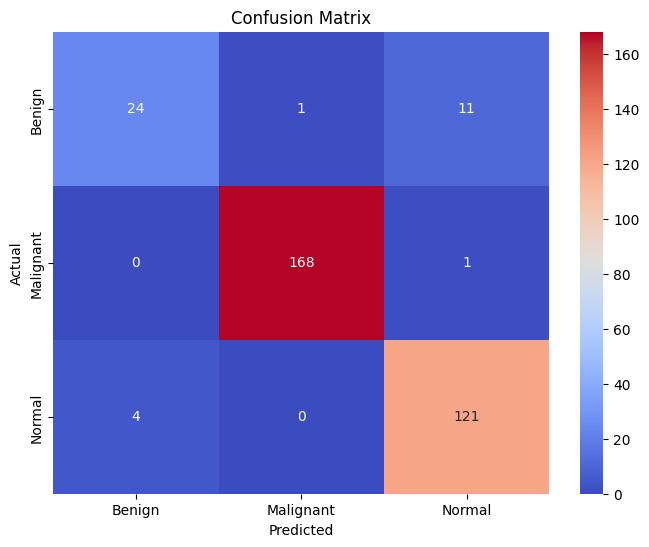


Accuracy: 0.9485

Recall (Weighted): 0.9485
Precision (Weighted): 0.9472

Overall Specificity: 0.9739
Overall Sensitivity: 0.8762


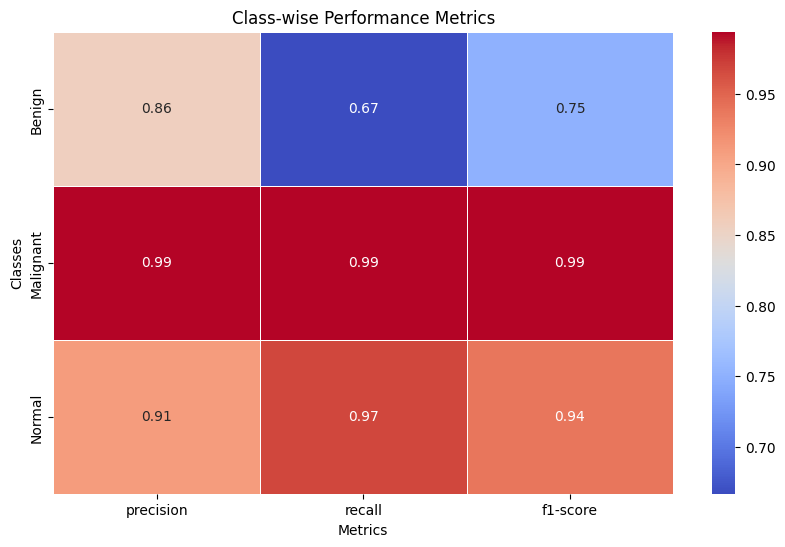


AUC-ROC (Weighted): 0.9950


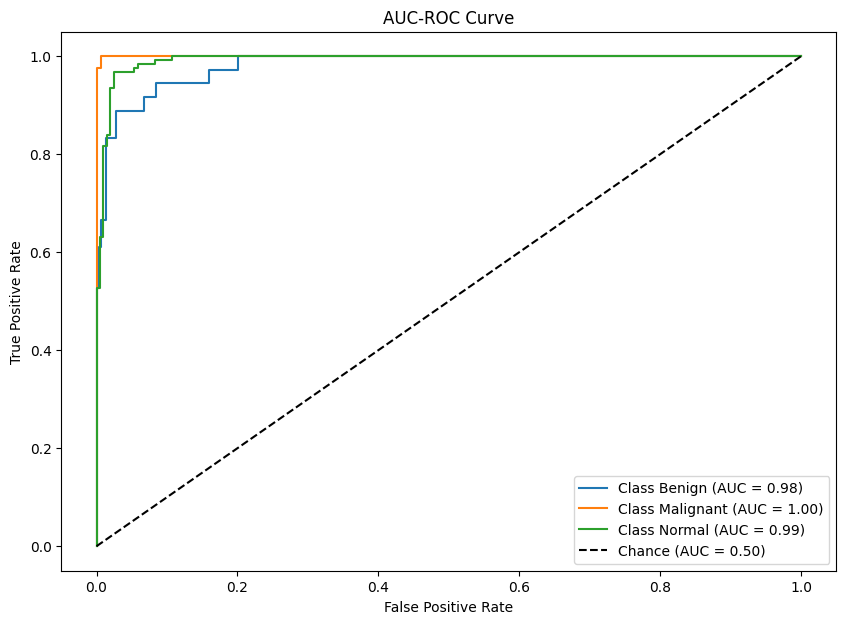

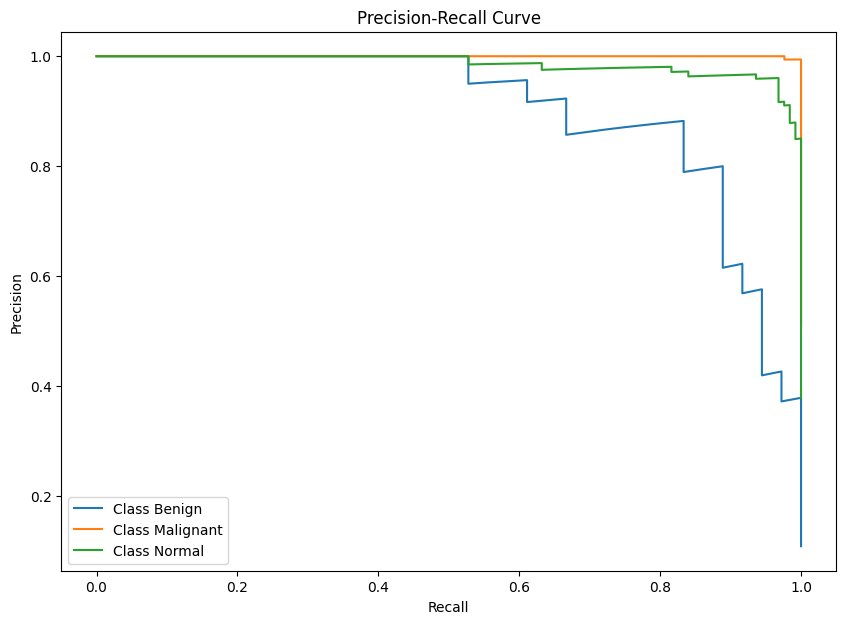

In [48]:
# Run defined function again
evaluate_predictions(y_test_final, y_pred_1_loaded, y_pred_bool_1_loaded)

### Model 2: MobileNet

In [41]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Define input for grayscale images
input_layer = Input(shape=(256, 256, 1))

# Convert grayscale to pseudo-RGB
rgb_layer = Conv2D(3, (3, 3), padding='same', activation=None)(input_layer)

# Load MobileNet with pre-trained weights
mobilenet_backbone = MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)  # Original input shape for MobileNet
)

# Pass the RGB output into MobileNet
mobilenet_output = mobilenet_backbone(rgb_layer)

# Add global average pooling and output layer
x = GlobalAveragePooling2D()(mobilenet_output)
output_layer = Dense(3, activation='softmax')(x)

# Create the full model
model2 = Model(inputs=input_layer, outputs=output_layer)

# Unfreeze the last few layers for fine-tuning
for layer in mobilenet_backbone.layers[-20:]:
    layer.trainable = True

# Compile the model
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Model summary
model2.summary()

/var/folders/vz/8f0dlrxd14g849p0gddrr1c00000gn/T/ipykernel_20763/2431538104.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_backbone = MobileNet(


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 8, 8, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,231,969 (12.33 MB)

 Trainable params: 3,210,081 (12.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [42]:
# Fitting CNN Model with validtion data
history2 = model2.fit(X_train_aug, y_train_aug, batch_size=8, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.7835 - loss: 0.6742 - val_accuracy: 0.7021 - val_loss: 0.8237
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step - accuracy: 0.9224 - loss: 0.1996 - val_accuracy: 0.8632 - val_loss: 1.0881
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.9424 - loss: 0.1681 - val_accuracy: 0.9149 - val_loss: 0.2451
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.9543 - loss: 0.1367 - val_accuracy: 0.5988 - val_loss: 1.8434
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.9794 - loss: 0.0517 - val_accuracy: 0.9605 - val_loss: 0.1305
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.9538 - loss: 0.1353 - val_accuracy: 0.8359 - val_loss: 0.4741
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.9859 - loss: 0.0464 - val_accuracy: 0.9240 - val_loss: 0.2490
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 602s 2s/step - accuracy: 0.9744 - loss: 0.0786 - val_accu

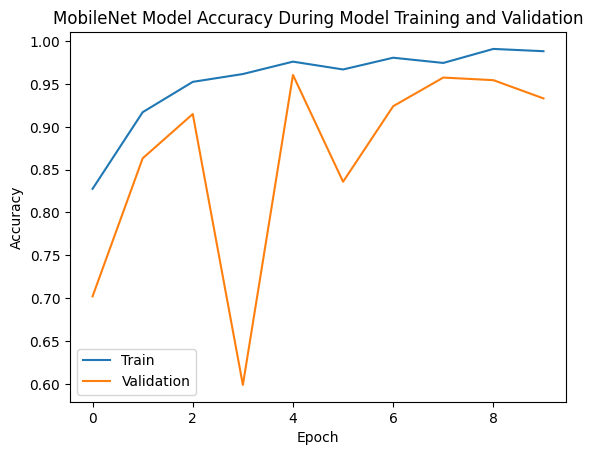

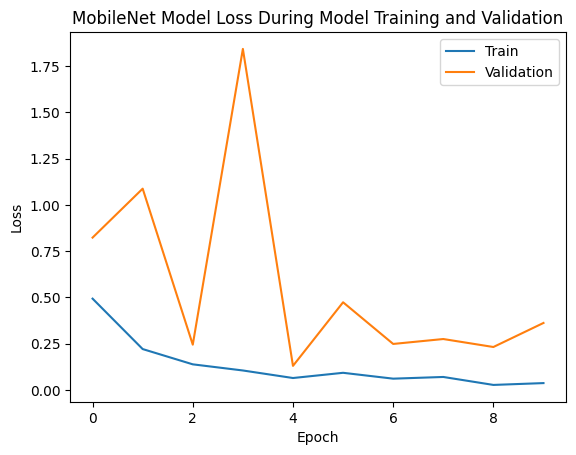

In [43]:
# print validation accuracy and loss over epoch
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.title('MobileNet Model Accuracy During Model Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('MobileNet Model Loss During Model Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Evaluation

In [44]:
# Make Predictions
y_pred_2 = model2.predict(X_test_final, verbose=1)
# Convert predicted probabities to class 
y_pred_bool_2 = np.argmax(y_pred_2, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step



Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.39      0.56        36
   Malignant       1.00      0.99      1.00       169
      Normal       0.84      1.00      0.92       125

    accuracy                           0.93       330
   macro avg       0.95      0.79      0.82       330
weighted avg       0.94      0.93      0.92       330


Confusion Matrix:
[[ 14   0  22]
 [  0 168   1]
 [  0   0 125]]


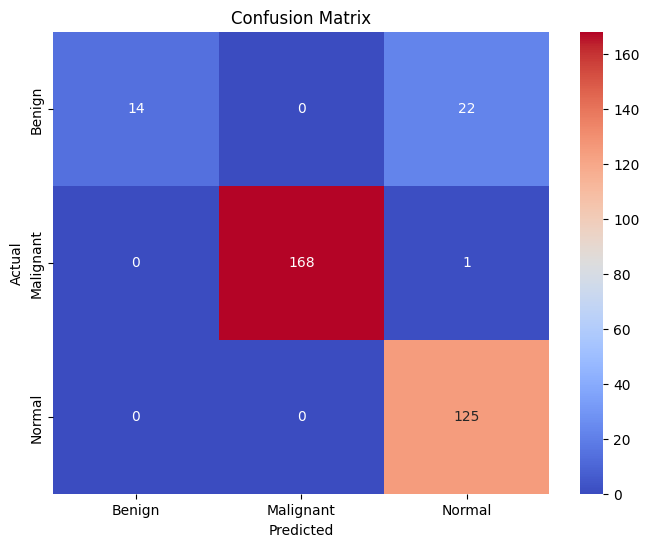


Accuracy: 0.9303

Recall (Weighted): 0.9303
Precision (Weighted): 0.9411

Overall Specificity: 0.9626
Overall Sensitivity: 0.7943


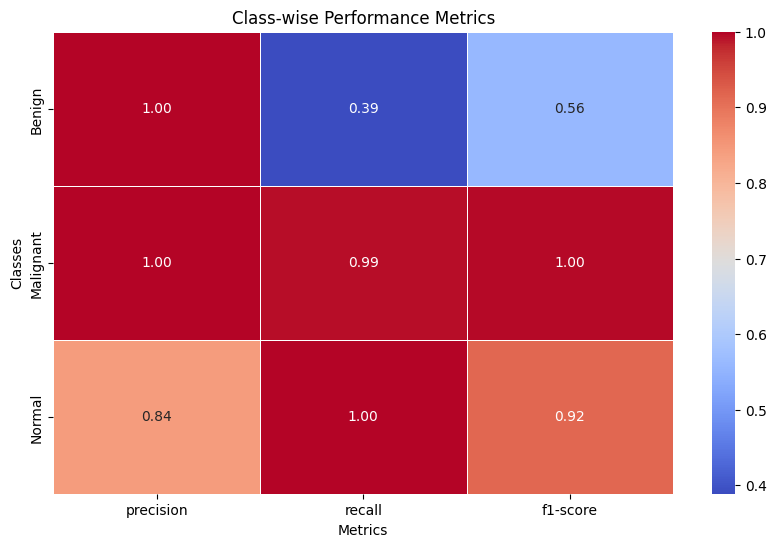


AUC-ROC (Weighted): 0.9910


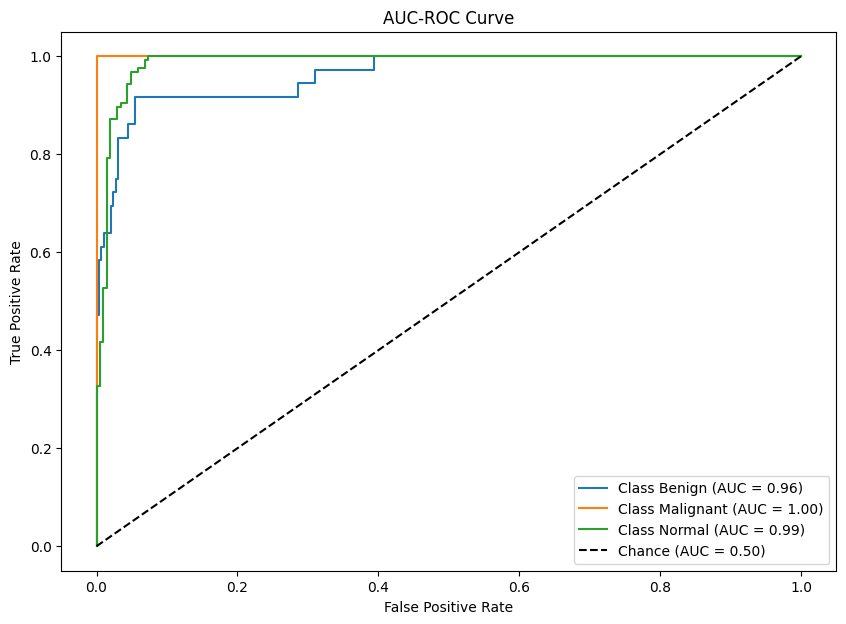

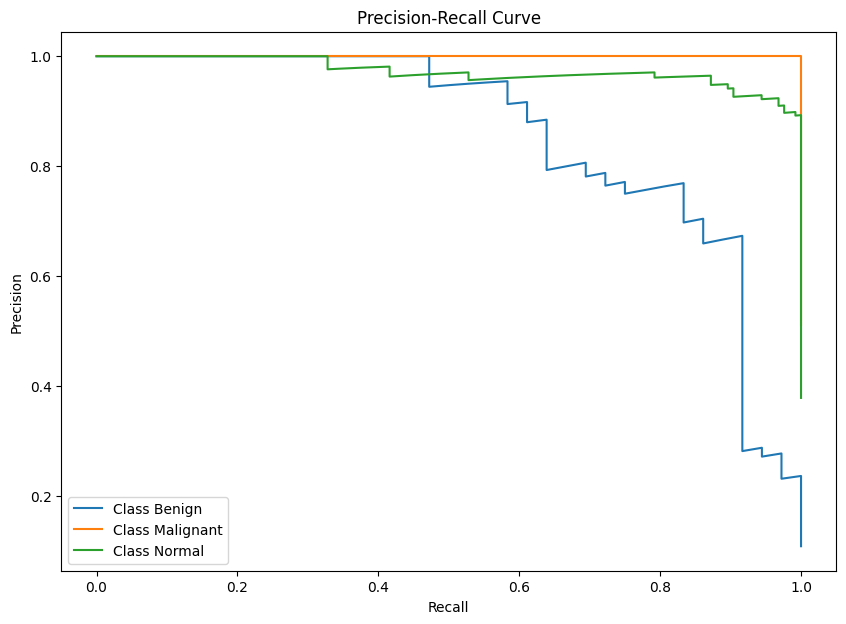

In [49]:
# run defined function
evaluate_predictions(y_test_final, y_pred_2, y_pred_bool_2)

#### Model Saving

In [50]:
model2.save("MobileNet_model(final).keras")

In [51]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model2 = load_model("MobileNet_model(final).keras")

In [52]:
# Make Predictions from the loaded model (to verify impact)

y_pred_2_loaded = loaded_model2.predict(X_test_final, verbose=1)
y_pred_bool_2_loaded = np.argmax(y_pred_2_loaded, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step



Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.39      0.56        36
   Malignant       1.00      0.99      1.00       169
      Normal       0.84      1.00      0.92       125

    accuracy                           0.93       330
   macro avg       0.95      0.79      0.82       330
weighted avg       0.94      0.93      0.92       330


Confusion Matrix:
[[ 14   0  22]
 [  0 168   1]
 [  0   0 125]]


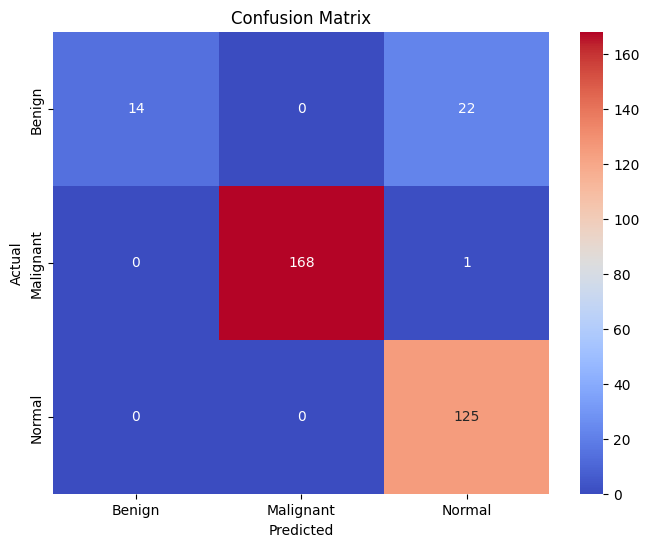


Accuracy: 0.9303

Recall (Weighted): 0.9303
Precision (Weighted): 0.9411

Overall Specificity: 0.9626
Overall Sensitivity: 0.7943


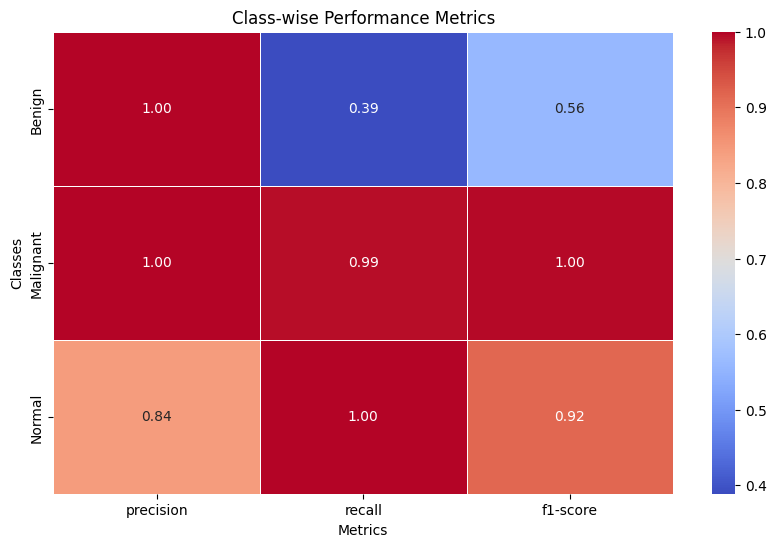


AUC-ROC (Weighted): 0.9910


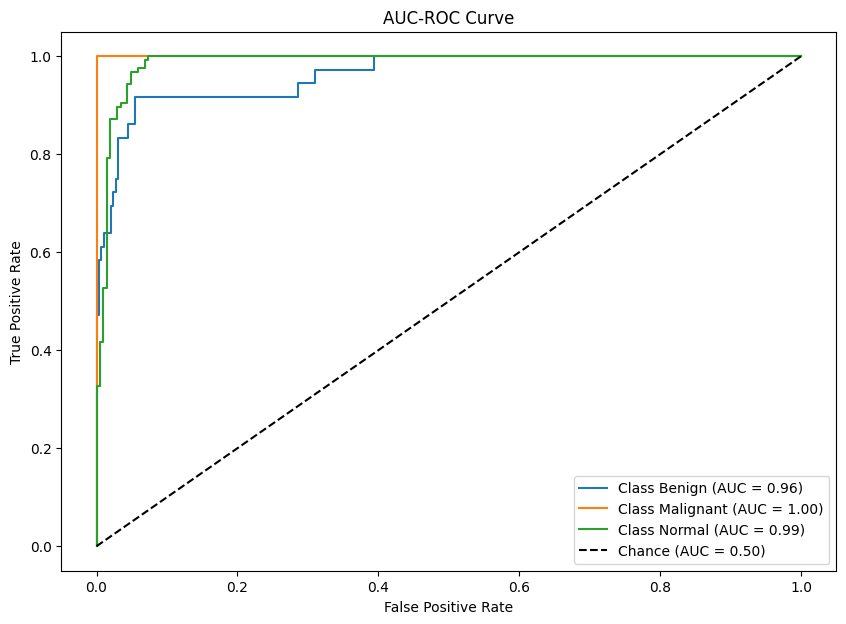

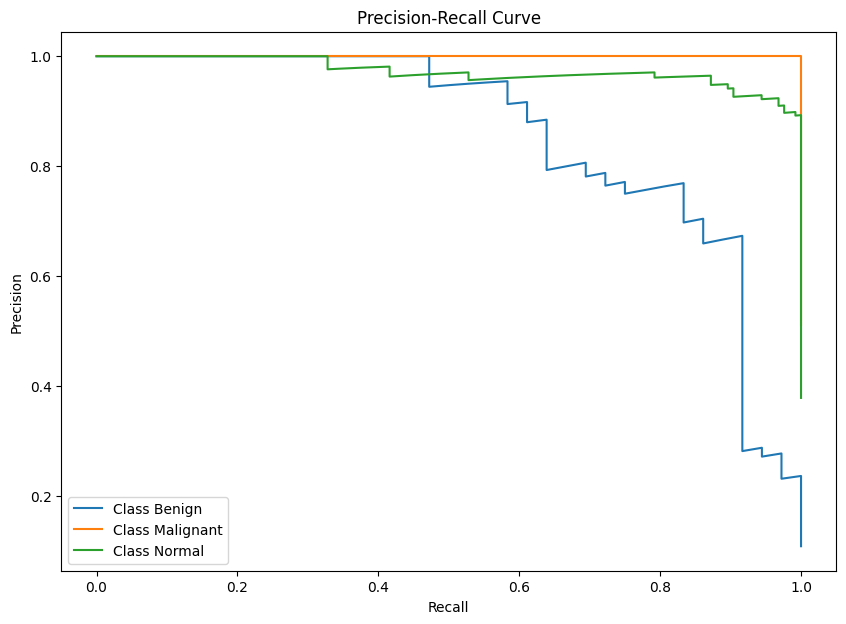

In [53]:
# Run defined function again
evaluate_predictions(y_test_final, y_pred_2_loaded, y_pred_bool_2_loaded)

### Model 3: EfficientNet

In [54]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Define input for grayscale images
input_layer = Input(shape=(256, 256, 1))

# Convert grayscale to pseudo-RGB
rgb_layer = Conv2D(3, (3, 3), padding='same', activation=None)(input_layer)

# Load EfficientNetB0 with pre-trained weights
efficientnet_backbone = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)  # Original input shape for EfficientNetB0
)

# Pass the RGB output into EfficientNet
efficientnet_output = efficientnet_backbone(rgb_layer)

# Add global average pooling and output layer
x = GlobalAveragePooling2D()(efficientnet_output)
output_layer = Dense(3, activation='softmax')(x)

# Create the full model
model3 = Model(inputs=input_layer, outputs=output_layer)

# Unfreeze the last few layers of EfficientNet for fine-tuning
for layer in efficientnet_backbone.layers[-20:]:
    layer.trainable = True

# Compile the model
model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Model summary
model3.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,444 (15.46 MB)

 Trainable params: 4,011,421 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [55]:
# Fitting CNN Model with validtion data
history3 = model3.fit(X_train_aug, y_train_aug, batch_size=8, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 872s 3s/step - accuracy: 0.8050 - loss: 0.5002 - val_accuracy: 0.5106 - val_loss: 1.7805
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 814s 2s/step - accuracy: 0.8960 - loss: 0.2514 - val_accuracy: 0.7660 - val_loss: 0.6210
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 858s 3s/step - accuracy: 0.9483 - loss: 0.1423 - val_accuracy: 0.9514 - val_loss: 0.1917
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 842s 3s/step - accuracy: 0.9644 - loss: 0.1143 - val_accuracy: 0.9179 - val_loss: 0.2636
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 984s 3s/step - accuracy: 0.9746 - loss: 0.0741 - val_accuracy: 0.9574 - val_loss: 0.1202
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1824s 6s/step - accuracy: 0.9929 - loss: 0.0252 - val_accuracy: 0.7903 - val_loss: 0.7480
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.9803 - loss: 0.0457 - val_accuracy: 0.9635 - val_loss: 0.1510
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step - accuracy: 0.9801 - loss: 0.0535 - val_acc

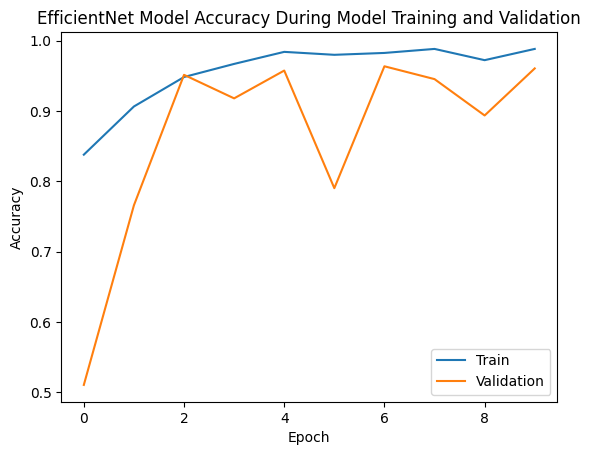

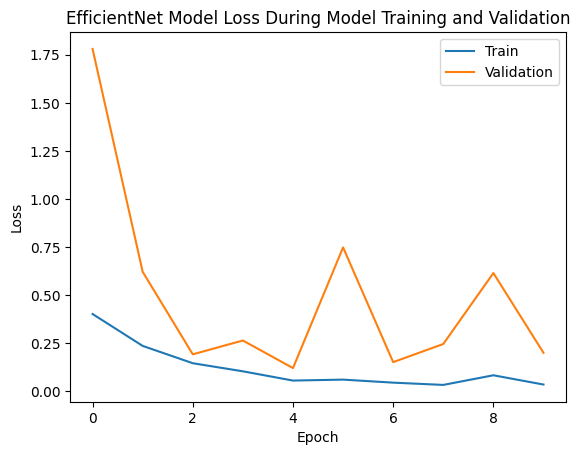

In [56]:
# print validation accuracy and loss over epoch
plt.plot(history3.history['accuracy'], label='Train')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.title('EfficientNet Model Accuracy During Model Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history3.history['loss'], label='Train')
plt.plot(history3.history['val_loss'], label='Validation')
plt.title('EfficientNet Model Loss During Model Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Evaluation

In [57]:
# Make Predictions
y_pred_3 = model3.predict(X_test_final, verbose=1)
# Convert predicted probabities to class 
y_pred_bool_3 = np.argmax(y_pred_3, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step



Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.69      0.81        36
   Malignant       1.00      1.00      1.00       169
      Normal       0.92      0.99      0.95       125

    accuracy                           0.96       330
   macro avg       0.96      0.90      0.92       330
weighted avg       0.96      0.96      0.96       330


Confusion Matrix:
[[ 25   0  11]
 [  0 169   0]
 [  1   0 124]]


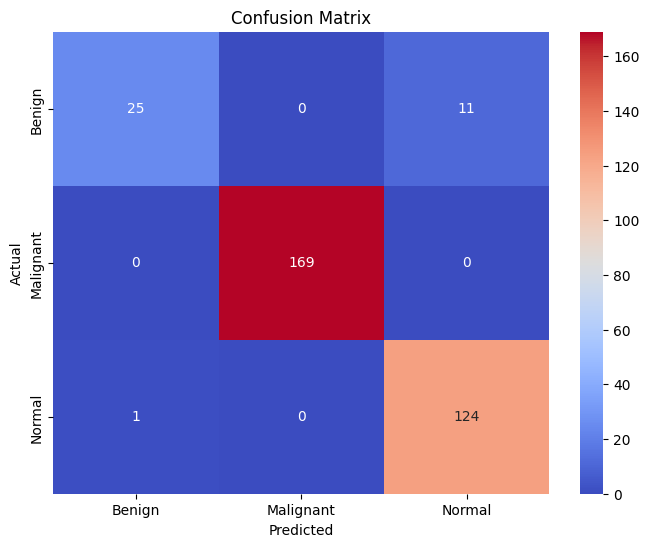


Accuracy: 0.9636

Recall (Weighted): 0.9636
Precision (Weighted): 0.9649

Overall Specificity: 0.9810
Overall Sensitivity: 0.8955


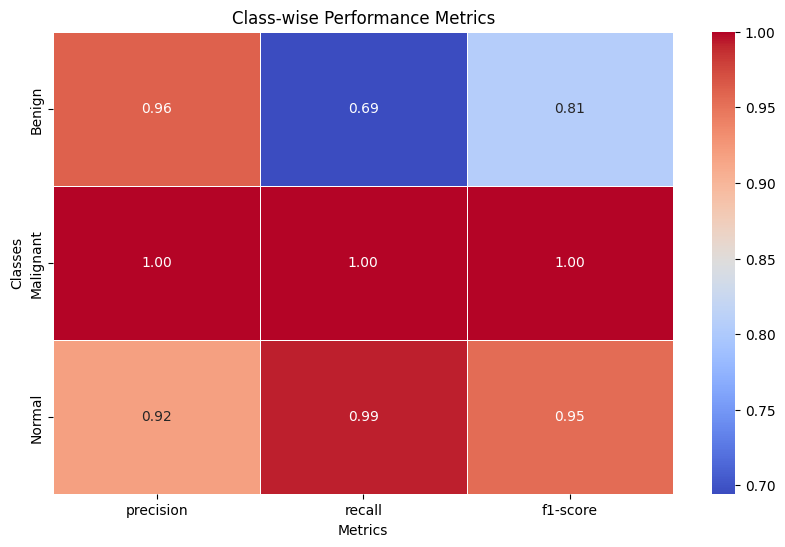


AUC-ROC (Weighted): 0.9935


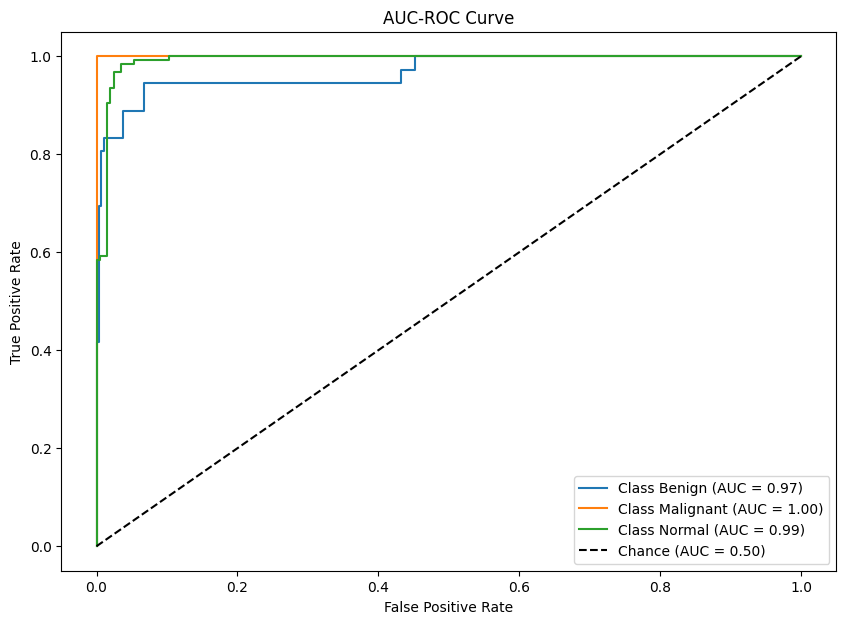

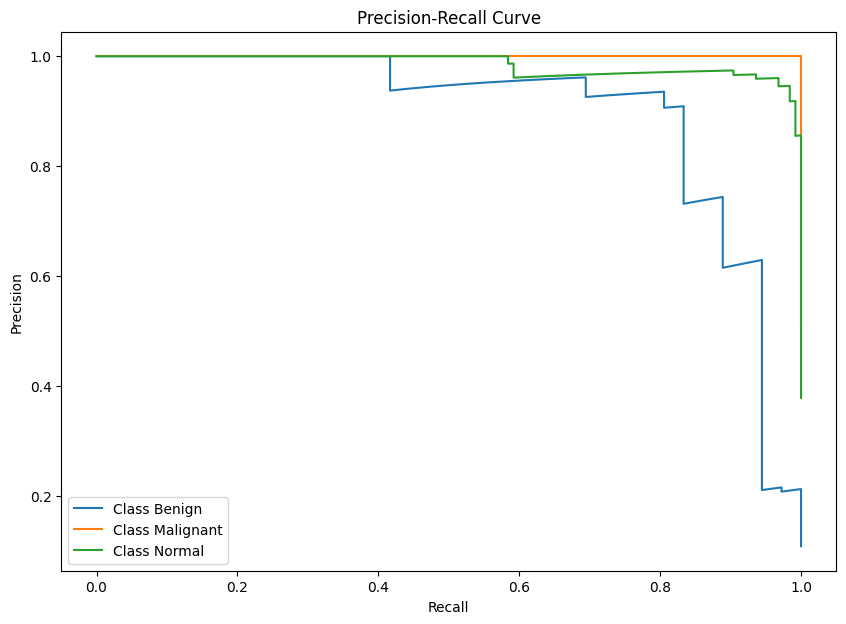

In [58]:
# run defined function
evaluate_predictions(y_test_final, y_pred_3, y_pred_bool_3)

## Comparison Plots

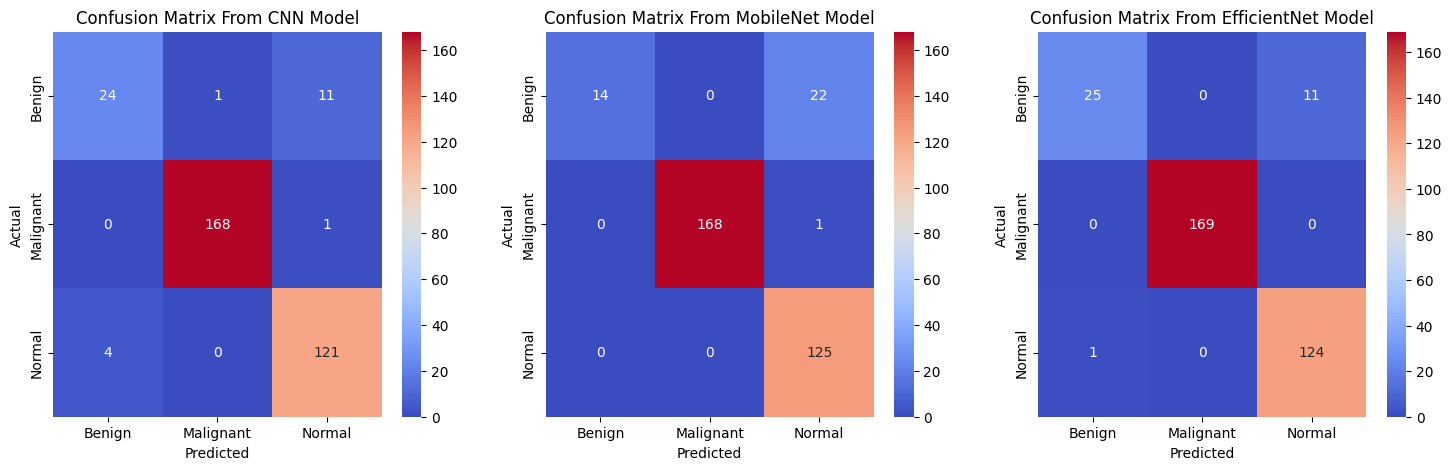

In [74]:
# Confusion Matrix
conf_matrix_1 = confusion_matrix(y_test_final, y_pred_bool_1)
# print("\nConfusion Matrix:")
# print(conf_matrix_1)

plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
sns.heatmap(conf_matrix_1, annot=True, cmap="coolwarm", fmt="d", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title("Confusion Matrix From CNN Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# plt.show()

conf_matrix_2 = confusion_matrix(y_test_final, y_pred_bool_2)
# print("\nConfusion Matrix:")
# print(conf_matrix_2)

# plt.figure(figsize=(8, 6))
plt.subplot(1,3,2)
sns.heatmap(conf_matrix_2, annot=True, cmap="coolwarm", fmt="d", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title("Confusion Matrix From MobileNet Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# plt.show()

conf_matrix_3 = confusion_matrix(y_test_final, y_pred_bool_3)
# print("\nConfusion Matrix:")
# print(conf_matrix_2)

# plt.figure(figsize=(8, 6))
plt.subplot(1,3,3)
sns.heatmap(conf_matrix_3, annot=True, cmap="coolwarm", fmt="d", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title("Confusion Matrix From EfficientNet Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



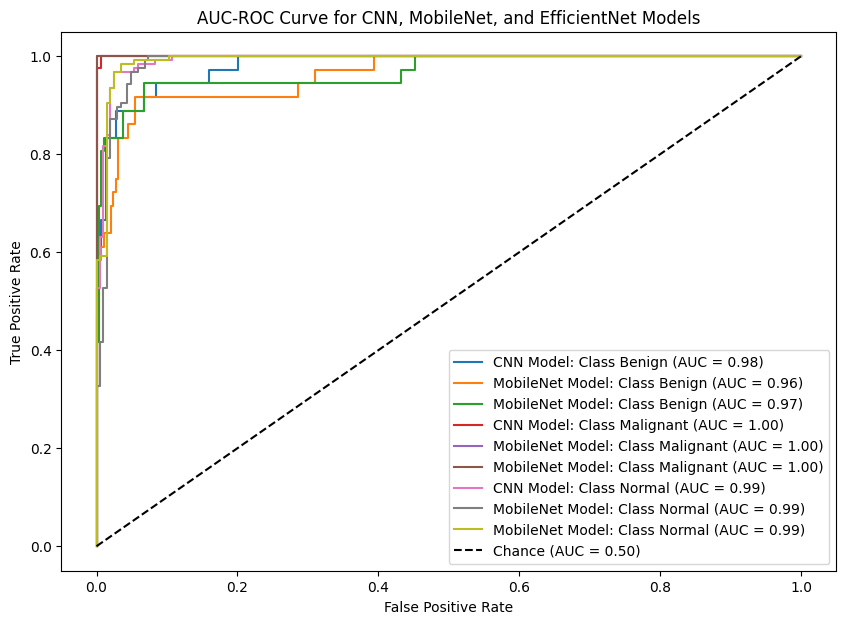

In [81]:
# Comparison for AUC-ROC Curve

plt.figure(figsize=(10, 7))

# AUC-ROC Curve (One-vs-Rest for Multiclass)
if len(np.unique(y_test_final)) > 2:
    # Binarize the labels for multiclass ROC calculation
    y_test_binary = np.zeros((y_test_final.size, len(np.unique(y_test_final))))
    for i, label in enumerate(y_test_final):
        y_test_binary[i, label] = 1

    # plt.figure(figsize=(10, 7))
    for i in range(3):
        fpr_1, tpr_1, _ = roc_curve(y_test_binary[:, i], y_pred_1[:, i])
        plt.plot(fpr_1, tpr_1, label=f"CNN Model: Class {class_labels[i]} (AUC = {auc(fpr_1, tpr_1):.2f})")

        fpr_2, tpr_2, _ = roc_curve(y_test_binary[:, i], y_pred_2[:, i])
        plt.plot(fpr_2, tpr_2, label=f"MobileNet Model: Class {class_labels[i]} (AUC = {auc(fpr_2, tpr_2):.2f})")

        fpr_3, tpr_3, _ = roc_curve(y_test_binary[:, i], y_pred_3[:, i])
        plt.plot(fpr_3, tpr_3, label=f"MobileNet Model: Class {class_labels[i]} (AUC = {auc(fpr_3, tpr_3):.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
    plt.title("AUC-ROC Curve for CNN, MobileNet, and EfficientNet Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()



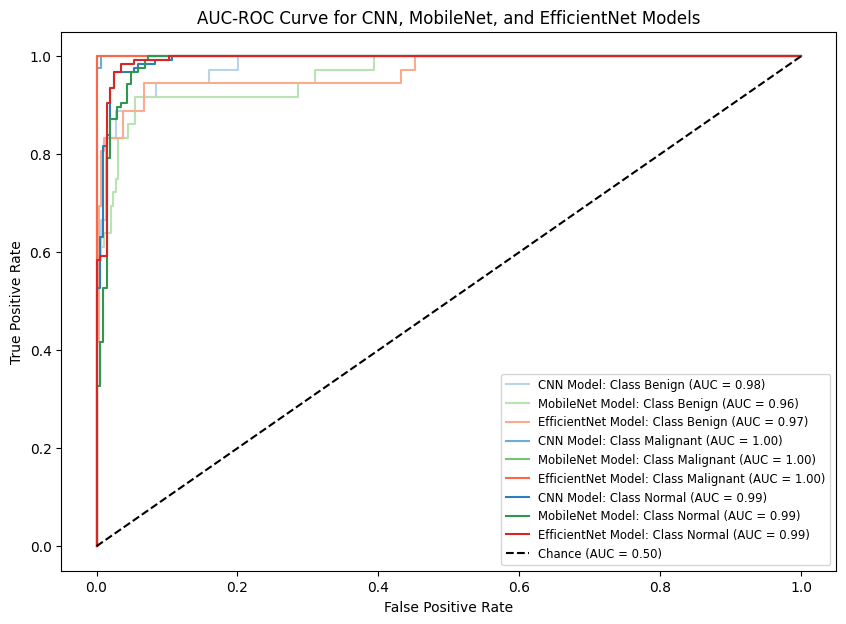

In [94]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import cm
# from sklearn.metrics import auc, roc_curve
import matplotlib
# Generate color maps for each model

# matplotlib.colormaps.get_cmap(name)
cnn_cmap = matplotlib.colormaps.get_cmap("Blues")      # Shades of blue
# cnn_cmap = matplotlib.colormaps.get_cmap("Blues", len(np.unique(y_test_final)))      # Shades of blue
mobilenet_cmap = matplotlib.colormaps.get_cmap("Greens")  # Shades of green
# mobilenet_cmap = matplotlib.colormaps.get_cmap("Greens", len(np.unique(y_test_final)))  # Shades of green
efficientnet_cmap = matplotlib.colormaps.get_cmap("Reds") # Shades of red
# efficientnet_cmap = matplotlib.colormaps.get_cmap("Reds", len(np.unique(y_test_final))) # Shades of red

plt.figure(figsize=(10, 7))

if len(np.unique(y_test_final)) > 2:
    # Binarize the labels for multiclass ROC calculation
    y_test_binary = np.zeros((y_test_final.size, len(np.unique(y_test_final))))
    for i, label in enumerate(y_test_final):
        y_test_binary[i, label] = 1
    
    # Narrower color range
    color_range = np.linspace(0.3, 0.7, len(np.unique(y_test_final)))

    # Plot for each class and model
    for i in range(len(np.unique(y_test_final))):
        # CNN Model
        fpr_1, tpr_1, _ = roc_curve(y_test_binary[:, i], y_pred_1[:, i])
        plt.plot(
            fpr_1,
            tpr_1,
            label=f"CNN Model: Class {class_labels[i]} (AUC = {auc(fpr_1, tpr_1):.2f})",
            color=cnn_cmap(color_range[i])
        )

        # MobileNet Model
        fpr_2, tpr_2, _ = roc_curve(y_test_binary[:, i], y_pred_2[:, i])
        plt.plot(
            fpr_2,
            tpr_2,
            label=f"MobileNet Model: Class {class_labels[i]} (AUC = {auc(fpr_2, tpr_2):.2f})",
            color=mobilenet_cmap(color_range[i])
        )

        # EfficientNet Model
        fpr_3, tpr_3, _ = roc_curve(y_test_binary[:, i], y_pred_3[:, i])
        plt.plot(
            fpr_3,
            tpr_3,
            label=f"EfficientNet Model: Class {class_labels[i]} (AUC = {auc(fpr_3, tpr_3):.2f})",
            color=efficientnet_cmap(color_range[i])
        )

    # Add diagonal line for random chance
    plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")

    # Customize plot
    plt.title("AUC-ROC Curve for CNN, MobileNet, and EfficientNet Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize="small")
    plt.show()


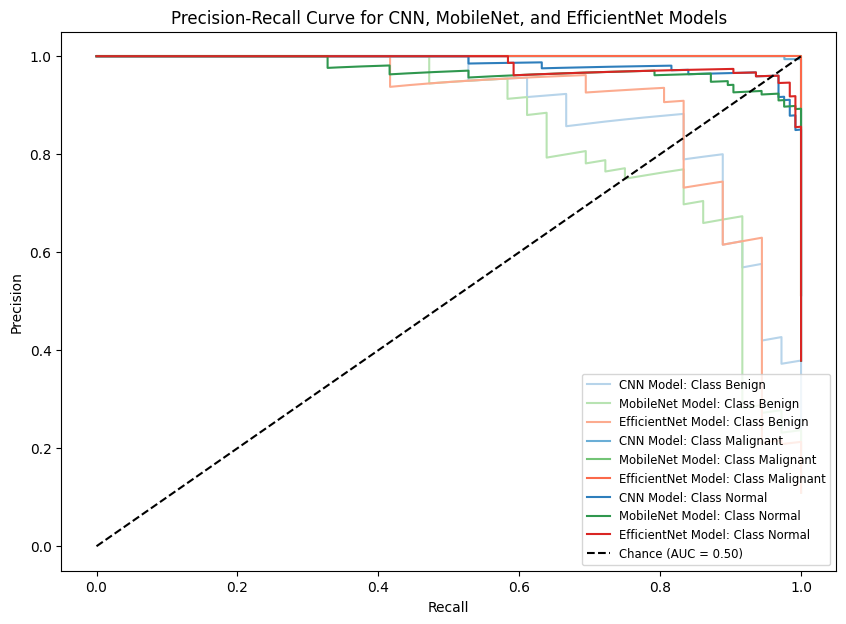

In [99]:
# Precision-Recall Curves

import matplotlib

cnn_cmap = matplotlib.colormaps.get_cmap("Blues")      # Shades of blue
mobilenet_cmap = matplotlib.colormaps.get_cmap("Greens")  # Shades of green
efficientnet_cmap = matplotlib.colormaps.get_cmap("Reds") # Shades of red

plt.figure(figsize=(10, 7))

if len(np.unique(y_test_final)) > 2:
    # Binarize the labels for multiclass ROC calculation
    y_test_binary = np.zeros((y_test_final.size, len(np.unique(y_test_final))))
    for i, label in enumerate(y_test_final):
        y_test_binary[i, label] = 1
    
    # Narrower color range
    color_range = np.linspace(0.3, 0.7, len(np.unique(y_test_final)))

    # Plot for each class and model
    for i in range(len(np.unique(y_test_final))):
        # CNN Model
        precision_1, recall_1, _ = precision_recall_curve(y_test_binary[:, i], y_pred_1[:, i])
        plt.plot(recall_1, precision_1, label=f"CNN Model: Class {class_labels[i]}", color=cnn_cmap(color_range[i]))

        # MobileNet Model
        precision_2, recall_2, _ = precision_recall_curve(y_test_binary[:, i], y_pred_2[:, i])
        plt.plot(recall_2, precision_2, label=f"MobileNet Model: Class {class_labels[i]}", color=mobilenet_cmap(color_range[i]))

        # EfficientNet Model
        precision_3, recall_3, _ = precision_recall_curve(y_test_binary[:, i], y_pred_3[:, i])
        plt.plot(recall_3, precision_3, label=f"EfficientNet Model: Class {class_labels[i]}", color=efficientnet_cmap(color_range[i]))

    # Add diagonal line for random chance
    plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")

    # Customize plot
    plt.title("Precision-Recall Curve for CNN, MobileNet, and EfficientNet Models")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower right", fontsize="small")
    plt.show()



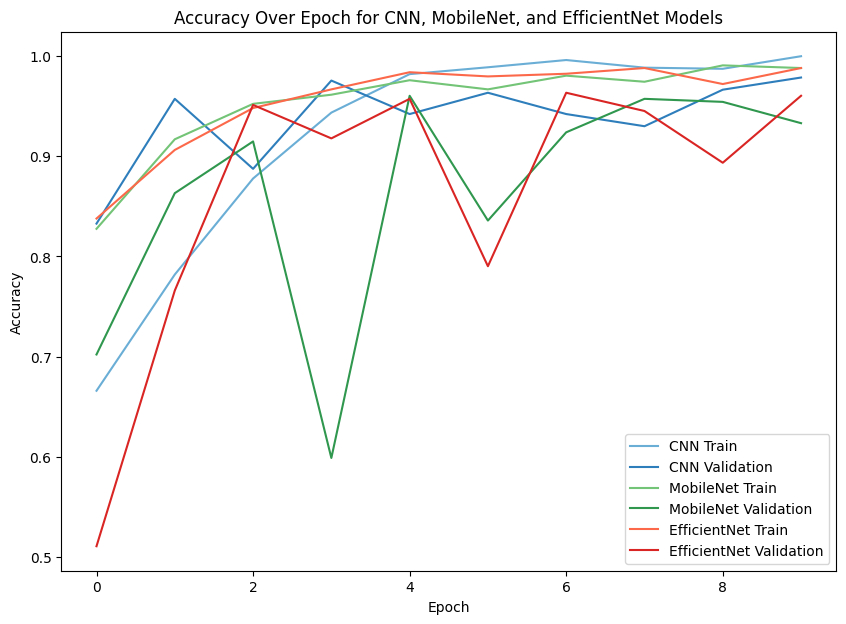

In [104]:
import matplotlib
import matplotlib.pyplot as plt

# Generate color maps with a narrower range for each model
cnn_cmap = matplotlib.colormaps.get_cmap("Blues")
mobilenet_cmap = matplotlib.colormaps.get_cmap("Greens")
efficientnet_cmap = matplotlib.colormaps.get_cmap("Reds")

# Narrow color range for consistency
color_range = [0.5, 0.7]  # Mid-range colors for better distinction

plt.figure(figsize=(10, 7))

# CNN Model
plt.plot(
    history1.history['accuracy'],
    label='CNN Train',
    color=cnn_cmap(color_range[0])
)
plt.plot(
    history1.history['val_accuracy'],
    label='CNN Validation',
    color=cnn_cmap(color_range[1])
)

# MobileNet Model
plt.plot(
    history2.history['accuracy'],
    label='MobileNet Train',
    color=mobilenet_cmap(color_range[0])
)
plt.plot(
    history2.history['val_accuracy'],
    label='MobileNet Validation',
    color=mobilenet_cmap(color_range[1])
)

# EfficientNet Model
plt.plot(
    history3.history['accuracy'],
    label='EfficientNet Train',
    color=efficientnet_cmap(color_range[0])
)
plt.plot(
    history3.history['val_accuracy'],
    label='EfficientNet Validation',
    color=efficientnet_cmap(color_range[1])
)

# Customize plot
plt.title('Accuracy Over Epoch for CNN, MobileNet, and EfficientNet Models')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


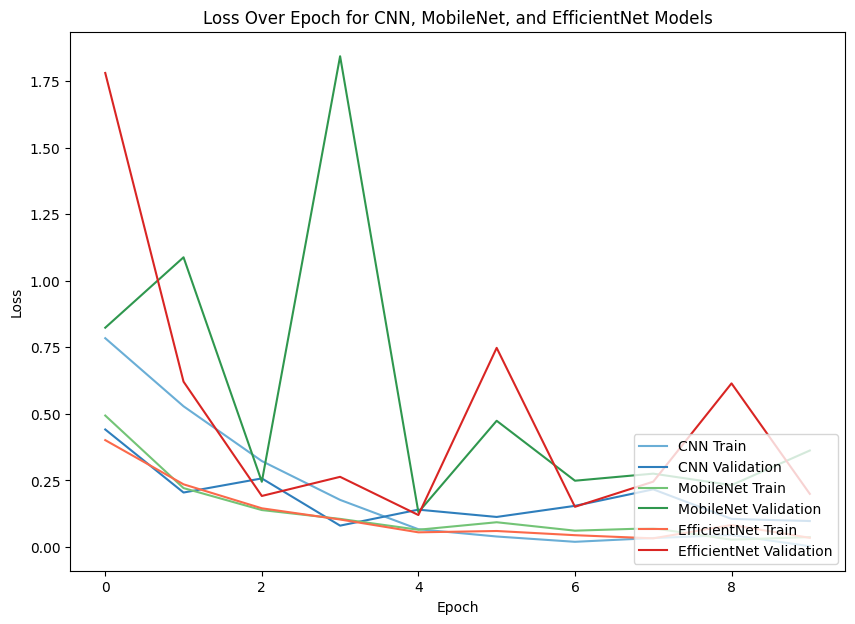

In [105]:
import matplotlib
import matplotlib.pyplot as plt

# Generate color maps with a narrower range for each model
cnn_cmap = matplotlib.colormaps.get_cmap("Blues")
mobilenet_cmap = matplotlib.colormaps.get_cmap("Greens")
efficientnet_cmap = matplotlib.colormaps.get_cmap("Reds")

# Narrow color range for consistency
color_range = [0.5, 0.7]  # Mid-range colors for better distinction

plt.figure(figsize=(10, 7))

# CNN Model
plt.plot(
    history1.history['loss'],
    label='CNN Train',
    color=cnn_cmap(color_range[0])
)
plt.plot(
    history1.history['val_loss'],
    label='CNN Validation',
    color=cnn_cmap(color_range[1])
)

# MobileNet Model
plt.plot(
    history2.history['loss'],
    label='MobileNet Train',
    color=mobilenet_cmap(color_range[0])
)
plt.plot(
    history2.history['val_loss'],
    label='MobileNet Validation',
    color=mobilenet_cmap(color_range[1])
)

# EfficientNet Model
plt.plot(
    history3.history['loss'],
    label='EfficientNet Train',
    color=efficientnet_cmap(color_range[0])
)
plt.plot(
    history3.history['val_loss'],
    label='EfficientNet Validation',
    color=efficientnet_cmap(color_range[1])
)

# Customize plot
plt.title('Loss Over Epoch for CNN, MobileNet, and EfficientNet Models')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()